# Exploratory Data Analysis

## Environment and Dataset Setup

In [175]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

sns.set_theme()

In [176]:
# import data from csv
df = pd.read_csv('../data/homes.csv', parse_dates=['Date'])
df.head()

Status      MLS# Property Type  County         Style  Year Built  \
0     New  20023084        Rental  Fulton  Contemporary      1997.0   
1  Active  20023084        Rental  Fulton  Contemporary      1997.0   
2  Active  20023084        Rental  Fulton  Contemporary      1997.0   
3  Active  20023084        Rental  Fulton  Contemporary      1997.0   
4  Active  20023084        Rental  Fulton  Contemporary      1997.0   

  Master on Main                                            Rooms Kitchen  \
0            Yes  Bonus Room Family Room Foyer Great Room Library     NaN   
1            Yes  Foyer Bonus Room Family Room Great Room Library     NaN   
2            Yes  Foyer Bonus Room Family Room Great Room Library     NaN   
3            Yes  Foyer Bonus Room Family Room Great Room Library     NaN   
4            Yes  Bonus Room Family Room Foyer Great Room Library     NaN   

                                            Interior  ...  Other Sprinkler  \
0  Bookcases High Ceilings Double Vanity Two Stor...  ...      0         0   
1  Bookcases High Ceilings Double Vanity Two Stor...  ...      0         0   
2  Bookcases High Ceilings Double Vanity Two Stor...  ...      0         0   
3  Bookcases High Ceilings Double Vanity Two Stor...  ...      0         0   
4  Bookcases High Ceilings Double Vanity Two Stor...  ...      0         0   

  Veranda Water Feature           City State    Zip Latitude Longitude  \
0       0             0  Sandy Springs    GA  30342      NaN       NaN   
1       0             0  Sandy Springs    GA  30342      NaN       NaN   
2       0             0  Sandy Springs    GA  30342      NaN       NaN   
3       0             0  Sandy Springs    GA  30342      NaN       NaN   
4       0             0  Sandy Springs    GA  30342      NaN       NaN   

  Result_Addy  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  

[5 rows x 50 columns]

In [177]:
# use only most recent row for duplicates (if MLS# duplicated, use most recent entry)
rdf = df.sort_values('Date', ascending=False) # most recent come first
rdf.drop_duplicates('MLS#', keep='first', inplace=True, ignore_index=True)

In [178]:
# drop outlier rows

# if price > 10000, then drop entry since property is mistranscribed, an outlier, or not a rental
rdf.drop(rdf[rdf['Price'] > 10_000].index, axis=0, inplace=True)

# > 3 fireplaces
rdf.drop(rdf[rdf['Fireplaces'] > 3].index, axis=0, inplace=True)

# < 1 or > 6 bedrooms
rdf.drop(rdf[(rdf['Bedrooms'] < 1) | (rdf['Bedrooms'] > 6)].index, axis=0, inplace=True)

# < 1 or > 4 full baths
rdf.drop(rdf[(rdf['Full_Baths'] < 1) | (rdf['Full_Baths'] > 4)].index, axis=0, inplace=True)

# > 3 half baths
rdf.drop(rdf[rdf['Half_Baths'] > 3].index, axis=0, inplace=True)

# > 300 assoc
rdf.drop(rdf[rdf['Assoc'] > 100].index, axis=0, inplace=True)

# <= 0 or > 7000 sqft
rdf.drop(rdf[(rdf['SQFT_Int'] <= 0) | (rdf['SQFT_Int'] > 7000)].index, axis=0, inplace=True)

# <= 0 or > 10 lot_size_num
rdf.drop(rdf[(rdf['Lot_Size_Num'] <= 0) | (rdf['Lot_Size_Num'] > 5)].index, axis=0, inplace=True)

# reset index
rdf.reset_index(drop=True, inplace=True)

In [179]:
# dimensionality of dataset
print(f'{len(rdf.columns)} columns, {len(rdf)} rows')

# how many non-NaN datapoints in each column
notna_cols = rdf.notna().sum(axis=0)
#print(notna_cols)

# how many non-NaN datapoints in each row
notna_rows = rdf.notna().sum(axis=1)
#print(notna_rows)

# how many full rows and columns (no NaNs)?
print(f'{notna_rows.value_counts()[len(rdf.columns)]} full rows')
print(f'{notna_cols.value_counts()[len(rdf)]} full columns')
print()
print(notna_rows.value_counts()) #outputs in format (num values | num rows)

50 columns, 3507 rows
689 full rows
36 full columns

48    1126
47     703
50     689
49     616
46     167
45     132
44      51
43      17
42       4
41       2
dtype: int64


## Initial Exploration

In [180]:
# view columns of dataset and their unique values
uniques = pd.Series(dtype=object)
for col in rdf.columns:
    uniques[col] = list(rdf[col].unique()) + ['-']*(len(rdf) - len(rdf[col].unique()))

# view number of unique values for each column
num_uniques = pd.Series(dtype=int)
for col in rdf.columns:
    num_uniques[col] = [len(rdf[col].unique())]

# view value distributions per column (will repeat after one-hot encoding)
uniques_dist = pd.DataFrame()
for col in rdf.columns:
    counts = rdf[col].value_counts(normalize=True)
    uniques_dist[col] =  list(counts) + [0 for i in range(len(rdf) - len(counts))]

## Data Cleaning

In [181]:
# useful functions for keyword splitting

def flatten(lst): # flatten list of lists into single 1D list
    return [item for sub in lst for item in sub]

def remove(lst, val): # remove all instances of val from lst
    return list(filter(lambda x: x != val, lst))

def check_complete(col, keywords, df): # for manual extraction, check if all keywords listed (didn't miss any)
    res = ''
    for s in df[col].fillna(' '):
        op = s
        for kw in keywords:
          op = op.replace(kw, '')
        res += op
    if (checkstr := res.replace(',', '').strip()) ==  '': # if anything other than '' and ',' in output, a keyword was missed
        return True
    else:
        return checkstr

In [182]:
# convert 'Year Built' to 'Age'
rdf['Age'] = pd.Series([2022-y for y in rdf['Year Built']])

# simplify Water column
rdf['Water'] = rdf['Water'].replace(['Shared Well', 'Shared Well Well', 'Public Well'], 'Shared').replace(['Well', 'Private Well'], 'Private')
# rdf['Water'].value_counts(normalize=True)

# simplify Basement_Entry column
rdf['Basement_Entry'] = rdf['Basement_Entry'].replace('Both', 'Interior Exterior')

In [183]:
# explore lot size distribution
# def plot_lot_size(limits):
#     rdf[(rdf['Lot_Size_Num'] < limits[1]) & (rdf['Lot_Size_Num'] > limits[0])]['Lot_Size_Num'].plot.hist()
#     print(rdf[(rdf['Lot_Size_Num'] < limits[1]) & (rdf['Lot_Size_Num'] > limits[0])]['Lot_Size_Num'].describe())
# plot_lot_size((1,1000))

# convert all Lot_Size_Num to acres (all values over 110 converted to acre)
# replace .001 with nan, since those are mistranscribed
rdf['Lot_Size_Num'] = rdf['Lot_Size_Num'].replace(0.001, np.nan).apply(lambda x: x / 43560 if x >= 110 else x)

In [184]:
# replace Zipcode with median income, total households
# isolate relevant data from incomes dataset
income_df = pd.read_csv('../data/incomes.csv').set_index('Label (Grouping)').T.loc[:, ['Total', 'Median income (dollars)']]
income_df.rename(columns={'Total': 'Households', 'Median income (dollars)': 'Median Income'}, inplace=True)

for (row_index, row_data) in income_df.iterrows():
    if '!!Households!!' not in row_index:
        income_df.drop(row_index, axis=0, inplace=True)
    else:
        income_df.rename(index={row_index: row_index[6:11]}, inplace=True)

# some zipcodes have no associated data in income_df; check if any of these zipcodes are in our dataset
df_zips = rdf['Zipcode'].unique()
empty_zips = [z for (z, data) in income_df.iterrows() if data['Median Income'] == '-']
print(f'{len(set(df_zips) & set(empty_zips))} overlap')

0 overlap


In [185]:
# since there is no overlap, we are clear to drop these zipcodes from the df and convert the rest of the df into numeric values
for (row_index, row_data) in income_df.iterrows():
    if row_index in empty_zips:
        income_df.drop(row_index, axis=0, inplace=True)
    else:
        income_df.loc[row_index] = row_data.str.replace(',', '')

income_df['Households'] = income_df['Households'].astype(int)
income_df['Median Income'] = income_df['Median Income'].astype(int)
income_df.index = income_df.index.astype(int, copy=False) # convert index to int64 type
income_df.drop(income_df[income_df.index > 30620].index, axis=0, inplace=True) # nothing above 30620 in rdf so drop all data for zip codes >30620

In [186]:
# add Households and Median Income to rdf based on zipcode
income_df['Zipcode'] = income_df.index
rdf = pd.merge(rdf, income_df)

In [187]:
# drop all columns from dataframe that are clearly inconsequential or covered by other columns
to_drop = ['MLS#', 'Status', 'County', 'Street_Addy', 'Description', 'Elementary School', 'Middle School', 'High School', 'Date',
'City', 'State', 'Zip', 'Latitude', 'Longitude', 'Result_Addy', 'Year Built', 'Zipcode']
rdf.drop(to_drop, axis=1, inplace=True)

In [188]:
# split the entries of categorical and description-based columns (categorical multi-select) into keywords and save in dictionary
# remove 'None' from each type list to avoid multicollinearity (dummy encoding)
# no need for others because an entry can have a 1 in multiple columns (e.g. both Interior and Exterior basement entry)
types = {}

# Water
water_types = ['Public', 'Private', 'Shared']
types['Water'] = water_types
# print(check_complete('Water', water_types, rdf))

# Style
style_types = ['Brick 4 Side', 'Brick 3 Side', 'Ranch', 'Traditional', 'European', 'Craftsman', 'Brick Front', 'Contemporary',
'Other', 'Bungalow/Cottage', 'Brick/Frame', 'A-frame', 'Cape Cod', 'Country/Rustic', 'Colonial', 'Victorian', 'Stone Frame',
'French Provincial', 'Cluster', 'Tudor', 'Modular Home', 'Mediterranean']
# print(check_complete('Style', style_types, rdf))
types['Style'] = style_types

# Rooms
room_types = ['Keeping', 'Game', 'Great', 'Sun', 'Library', 'Den', 'Other', 'Laundry', 'Foyer', 'Exercise', 
'Family', 'Loft', 'Media', 'Office', 'Bonus']
# room_types = list(set(flatten([remove(s.replace(',', '').split(' '), 'Room') for s in df['Rooms'].fillna(' ')])) - set([''])) # automated
# print(check_complete('Rooms', room_types, rdf))
types['Rooms'] = room_types

# Kitchen
kitchen_types = ['Breakfast Bar', 'Breakfast Area', 'Pantry', 'Solid Surface Counters', 
'Breakfast Room', 'Kitchen Island', 'Walk-in Pantry', 'Second Kitchen', 'Country Kitchen']
# print(check_complete('Kitchen', kitchen_types, rdf))
types['Kitchen'] = kitchen_types

# Interior
interior_types = ['Other', 'Master On Main Level', 'High Ceilings', 'Double Vanity', 'Beamed Ceilings', 
'Two Story', 'Foyer', 'Rear Stairs', 'Separate Shower', 'Walk-In Closet(s)', 'Whirlpool Bath', 'In-Law Floorplan',
'Tile Bath', 'Wine Cellar', 'Soaking Tub', 'Pulldown Attic Stairs', 'Roommate Plan', 'Vaulted Ceiling(s)', 
'Tray Ceiling(s)', 'Bookcases', 'Split Bedroom Plan', 'Central Vacuum', 'Wet Bar', 'Sauna', 'Attic Expandable', 'Split']
# print(check_complete('Interior', interior_types, rdf))
types['Interior'] = interior_types

# Heating
heating_types = ['Forced Air', 'Natural Gas', 'Central', 'Zoned', 'Propane', 'Other', 'Electric', 'Heat Pump', 'Hot Water', 
'Dual', 'Common', 'Baseboard', 'Floor Furnace', 'Wood', 'Oil', 'Steam']
# print(check_complete('Heating', heating_types, rdf))
types['Heating'] = heating_types

# Cooling
cooling_types = ['Ceiling Fan(s)', 'Central Air', 'Electric', 'Zoned', 'Other', 'Dual', 'Common', 'Heat Pump', 'Gas', 
'Attic Fan', 'Whole House Fan', 'Window Unit(s)']
# print(check_complete('Cooling', cooling_types, rdf))
types['Cooling'] = cooling_types

# Construction
construction_types = ['Stucco', 'Stone', 'Brick', 'Wood Siding', 'Vinyl Siding', 'Other', 'Concrete', 'Rough-Sawn Lumber',
'Aluminum Siding', 'Press Board', 'Steel Siding', 'Block', 'Synthetic']
# print(check_complete('Construction', construction_types, rdf))
types['Construction'] = construction_types

# Roof
roof_types = ['Composition', 'Metal', 'Other', 'Concrete', 'Tile', 'Tar/Gravel', 'Slate', 'Wood', 'Tin']
# print(check_complete('Roof', roof_types, rdf))
types['Roof'] = roof_types

# Parking
parking_types = ['Garage Door Opener', 'Carport', 'Assigned', 'Kitchen Level', 'Off Street', 'Parking Pad',
'Side/Rear Entrance', 'Detached', 'Attached', 'Over 1 Space per Unit', 'Basement', 'RV/Boat Parking', 'Guest', 'Storage', 
'Parking Shed', 'Garage']
# print(check_complete('Parking', parking_types, rdf))
types['Parking'] = parking_types

# Amenities
amenities_types = ['Pool', 'Tennis Court(s)', 'Clubhouse', 'Gated', 'Golf', 'Park', 'Fitness Center', 'Playground', 'Street Lights',
'Walk To Shopping', 'Sidewalks', 'Walk To Schools', 'Swim Team', 'Tennis Team', 'Lake', 'Walk To Public Transit', 'Guest Lodging',
'Airport/Runway', 'Shared Dock', 'Racquetball', 'Marina', 'Retirement Community', 'Boat/Camper/Van Prkg']
# print(check_complete('Amenities', amenities_types, rdf))
types['Amenities'] = amenities_types

# Lot
lot_types = ['City Lot', 'Private', 'Level', 'Cul-De-Sac', 'Sloped', 'Open Lot', 'Corner Lot', 'Other', 'Zero Lot Line',
'Waterfall', 'Greenbelt', 'Steep Slope', 'Pasture']
# print(check_complete('Lot', lot_types, rdf))
types['Lot'] = lot_types

# Basement_Entry
entry_types = ['Interior', 'Exterior']
# print(check_complete('Basement_Entry', entry_types, rdf))
types['Basement_Entry'] = entry_types

In [189]:
# replace those columns with new binary ones based on keywords (one-hot encoding)
def add_one_hots(type_dict, df):
    edf = df.copy(deep=True) # new, expanded dataframe
    expansion = {}
    for og_col in type_dict.keys():
        for col in type_dict[og_col]:
            # print(col) # for debugging
            # create col in dataframe
            col_values = []
            # values in col = 1 if col name in row's og_col entry else 0
            for _, row in df.iterrows():
                row_str = str(row[og_col])
                if col in row_str:
                    code = 1
                else:
                    code = 0
                col_values.append(code)
            expansion[f'{og_col}: {col}'] = pd.Series(col_values)
            # edf[f'{og_col}: {col}'] = pd.Series(col_values)
        edf = edf.drop(og_col, axis=1)
    return pd.concat([edf, pd.DataFrame(expansion)], axis=1)

edf = add_one_hots(types, rdf)

In [190]:
# convert Master on Main (0-No, 1-Yes) and Property Type (0-Residential Lease, 1-Rental) into binary numerical values
# convert Basement_Finished into nominal value (higher number -> more finished, unknown = none or crawl, partial finished = unfinished)
def to_nums(col):
    if col.name in ('Master on Main', 'Property Type'):
        return pd.Series([1 if v in ('Yes', 'Rental') else 0 for v in col])
    elif col.name == 'Basement_Finished':
        return pd.Series([0 if v in ('Unknown', 'None or Crawl') else 0.5 if v in ('Partial Finished', 'Unfinished') else 1 for v in col])
    else:
        return col

ndf = edf.apply(to_nums) # numerical dataframe

## Missing Data Imputation

In [191]:
# need to impute values for Lot_Size_Num and Age
ndf.columns[ndf.isna().sum() != 0]

Index(['Lot_Size_Num', 'Age'], dtype='object')

In [192]:
# impute using multiple imputation to create full dataframe fdf
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

random_forest_imputer = RandomForestRegressor(n_estimators=10)
imputer = IterativeImputer(estimator=random_forest_imputer, initial_strategy='median', max_iter=20, random_state=0) # try with Bayesian Ridge and Random Forest regressors

fdf = pd.DataFrame(imputer.fit_transform(ndf.drop('Price', axis=1)))
fdf.columns = ndf.drop('Price', axis=1).columns
fdf['Price'] = ndf['Price']

imputed_rows = pd.concat((fdf[ndf['Lot_Size_Num'].isna()], fdf[ndf['Age'].isna()]))

In [193]:
# descriptive stats
fdf_descr = fdf.describe()

## Correlational Analysis

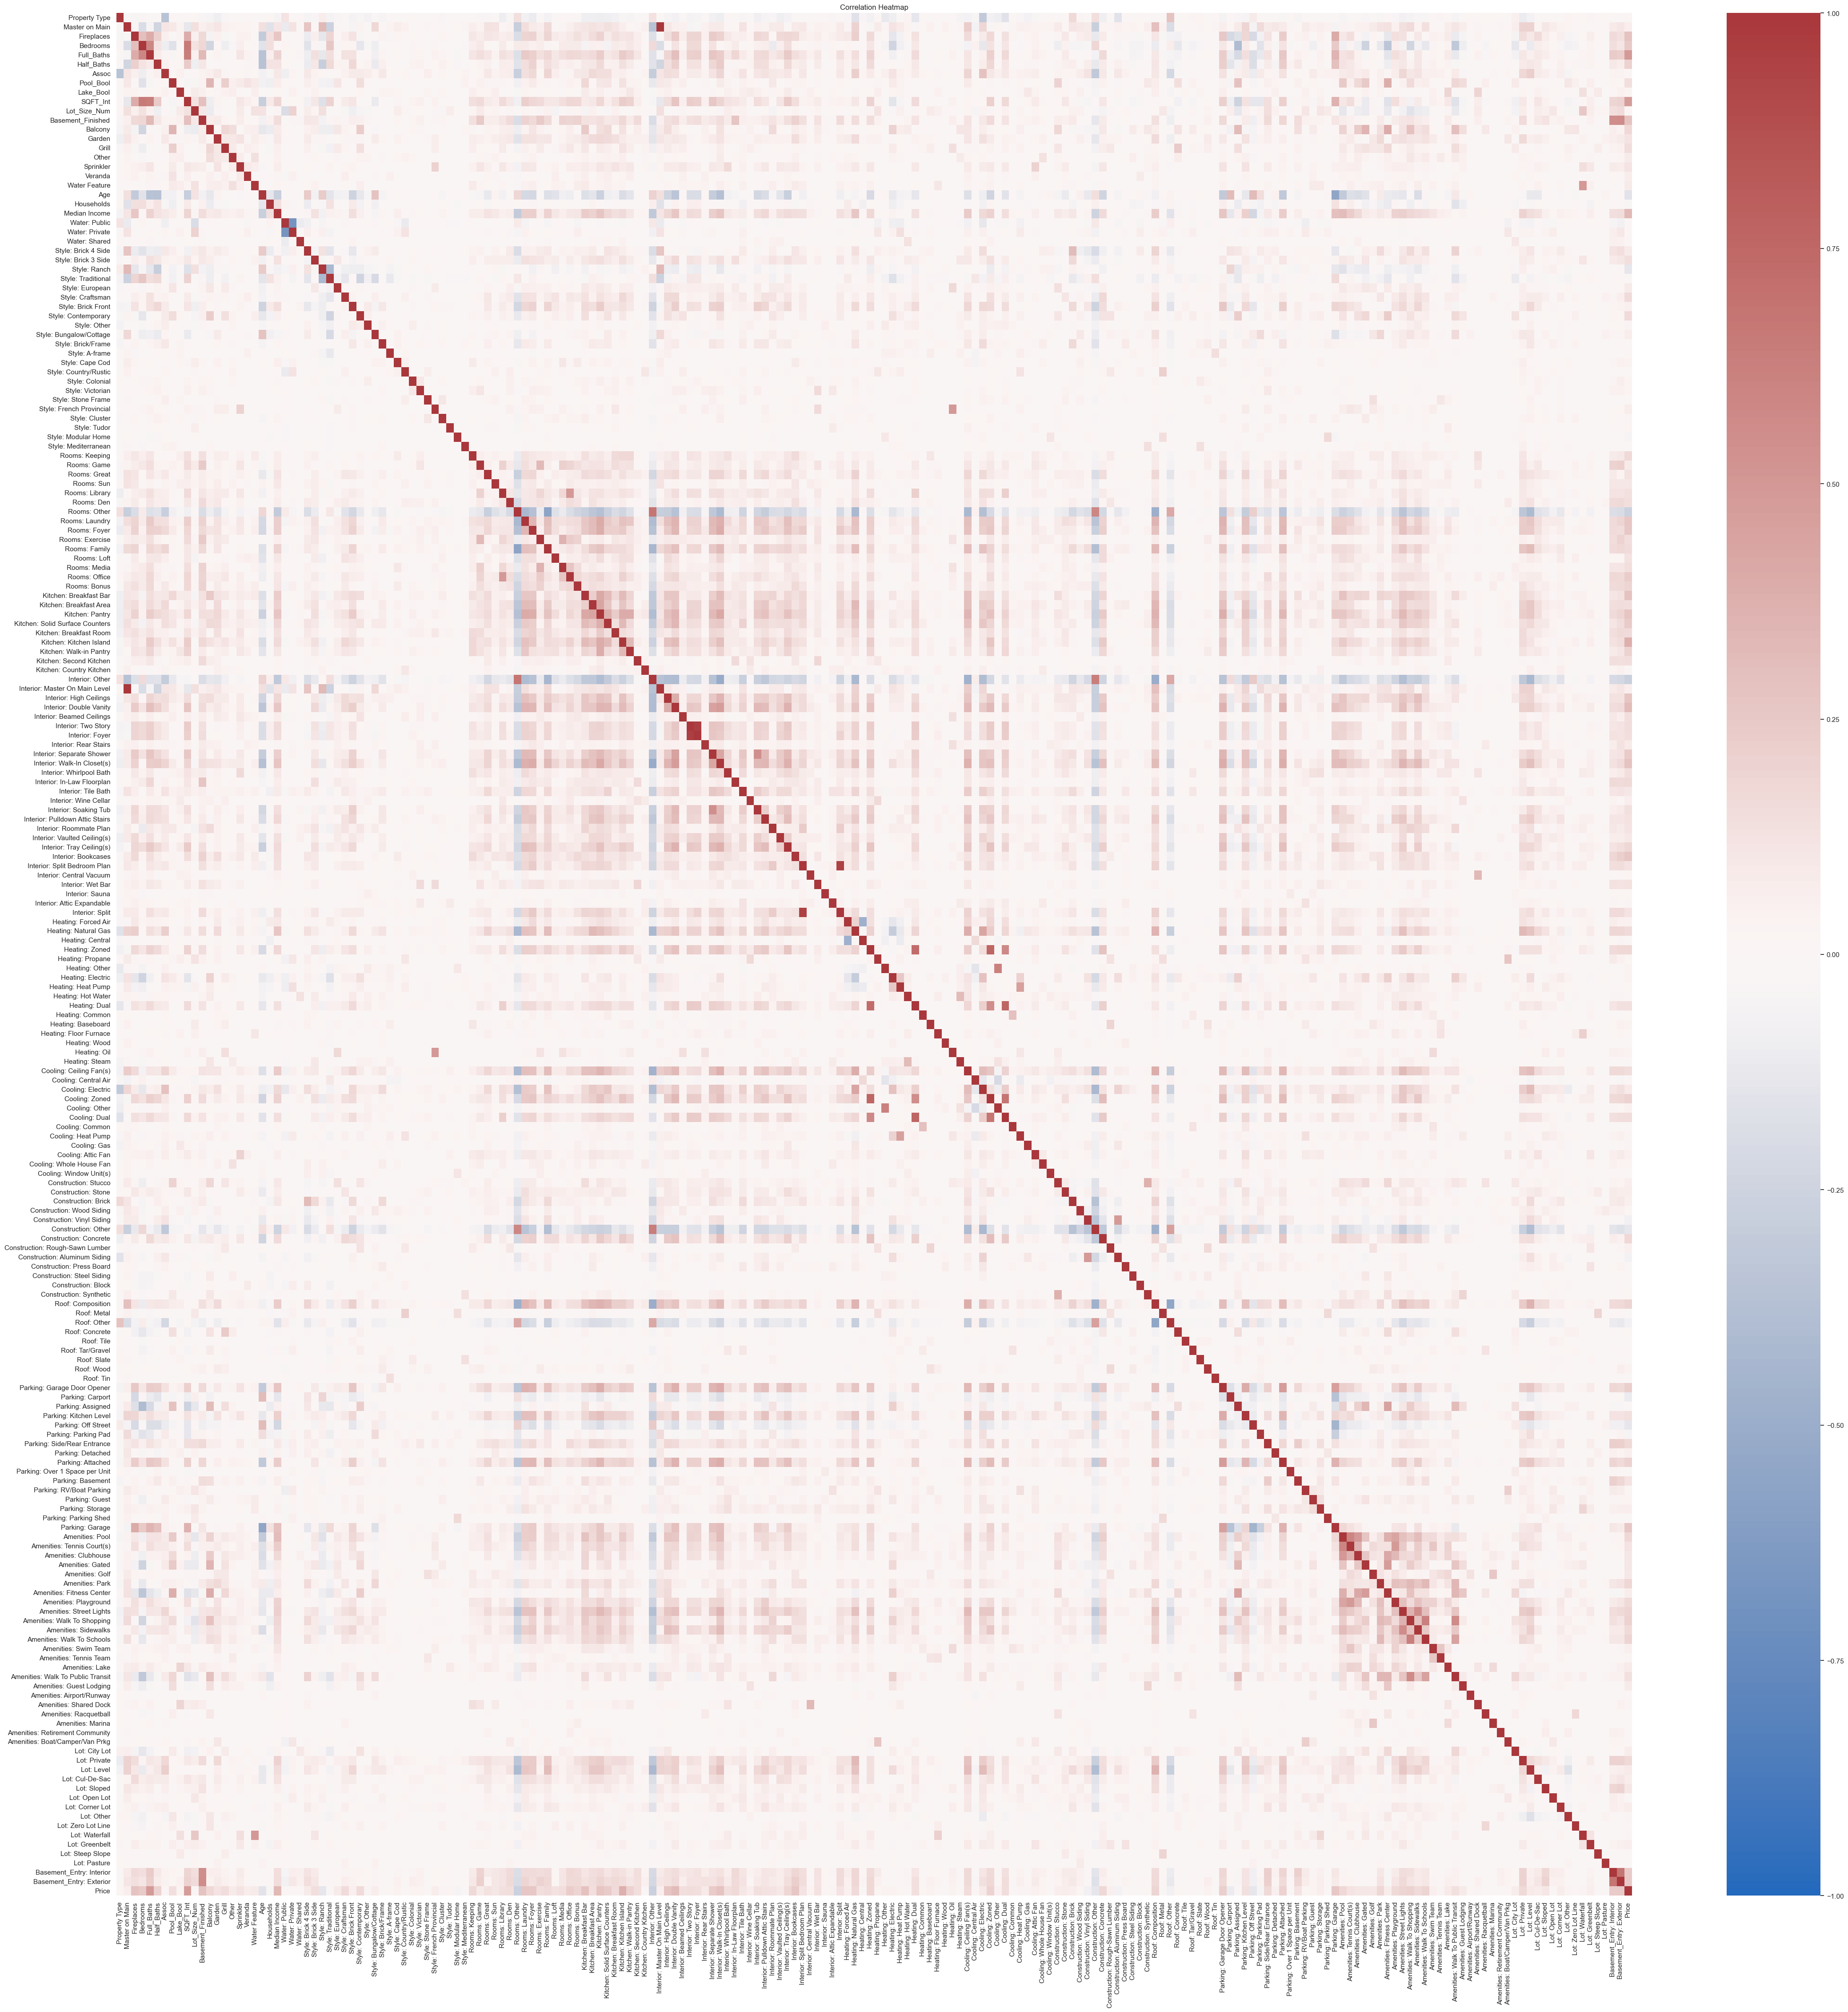

In [194]:
# correlation heatmap for all columns
corr = fdf.corr()
fig1 = plt.figure(figsize=(55,55))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, cmap='vlag')
plt.title('Correlation Heatmap')
plt.savefig('visuals/correlation_features.png')

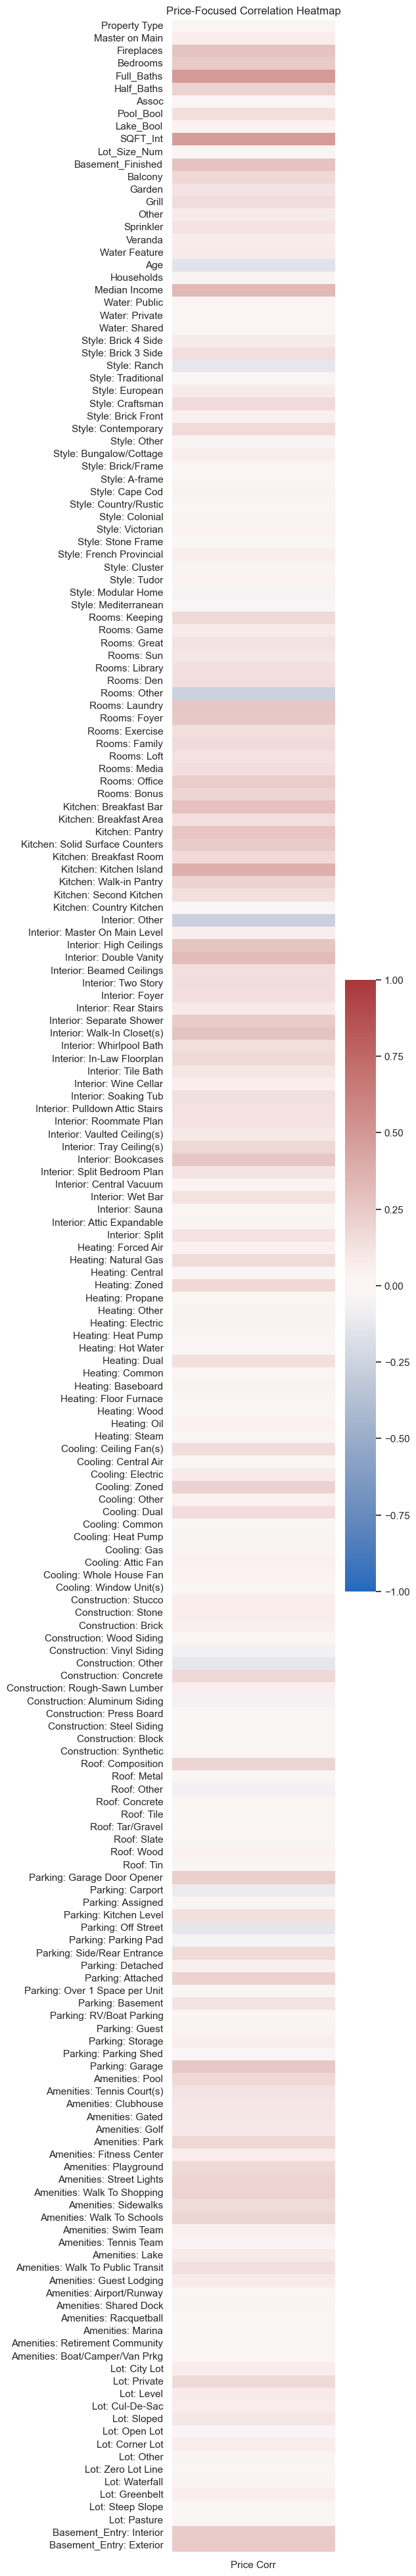

In [195]:
# correlation heatmap with focus on price
# as expected, there aren't any categories which strongly negatively correlate with price, as having a feature typically makes a home more valuable
price_corr = pd.DataFrame(corr.loc['Price']).drop('Price', axis=0).rename({'Price': 'Price Corr'}, axis=1)
fig2 = plt.figure(figsize=(4, 50))
price_heatmap = sns.heatmap(price_corr, vmin=-1, vmax=1, cmap='vlag')
plt.title('Price-Focused Correlation Heatmap')
plt.savefig('visuals/price_correlation_features.png')

In [196]:
# violin plot or histogram for each column (detect outliers and view column distributions)
fig3 = plt.figure(figsize=(100,100))
palette1 = sns.color_palette(palette='deep', n_colors=len(fdf.columns))
for i in range(len(fdf.columns)): # 203 columns
    plt.subplot(16, 13, i+1)
    if (col := ndf.iloc[:, i]).max() == 1 and len(col.unique()) == 2:
        hist = sns.histplot(data=ndf, x=col, bins=2, color=palette1[i])
    else:
        violin = sns.violinplot(data=fdf, y=col, color=palette1[i])

        # visibly mark outliers (values beyond the whiskers)
        q1, q3 = np.percentile(col, [25, 75])
        lower_whisker = q1 - (q3 - q1) * 1.5 # standard whisker is 1.5x interquartile range
        upper_whisker = q3 + (q3 - q1) * 1.5
        sns.scatterplot(y=col[(col < lower_whisker) | (col > upper_whisker)], x=0, color='crimson') #visibly mark outliers
plt.title('Column Distributions')
plt.savefig('visuals/dists_features.png')

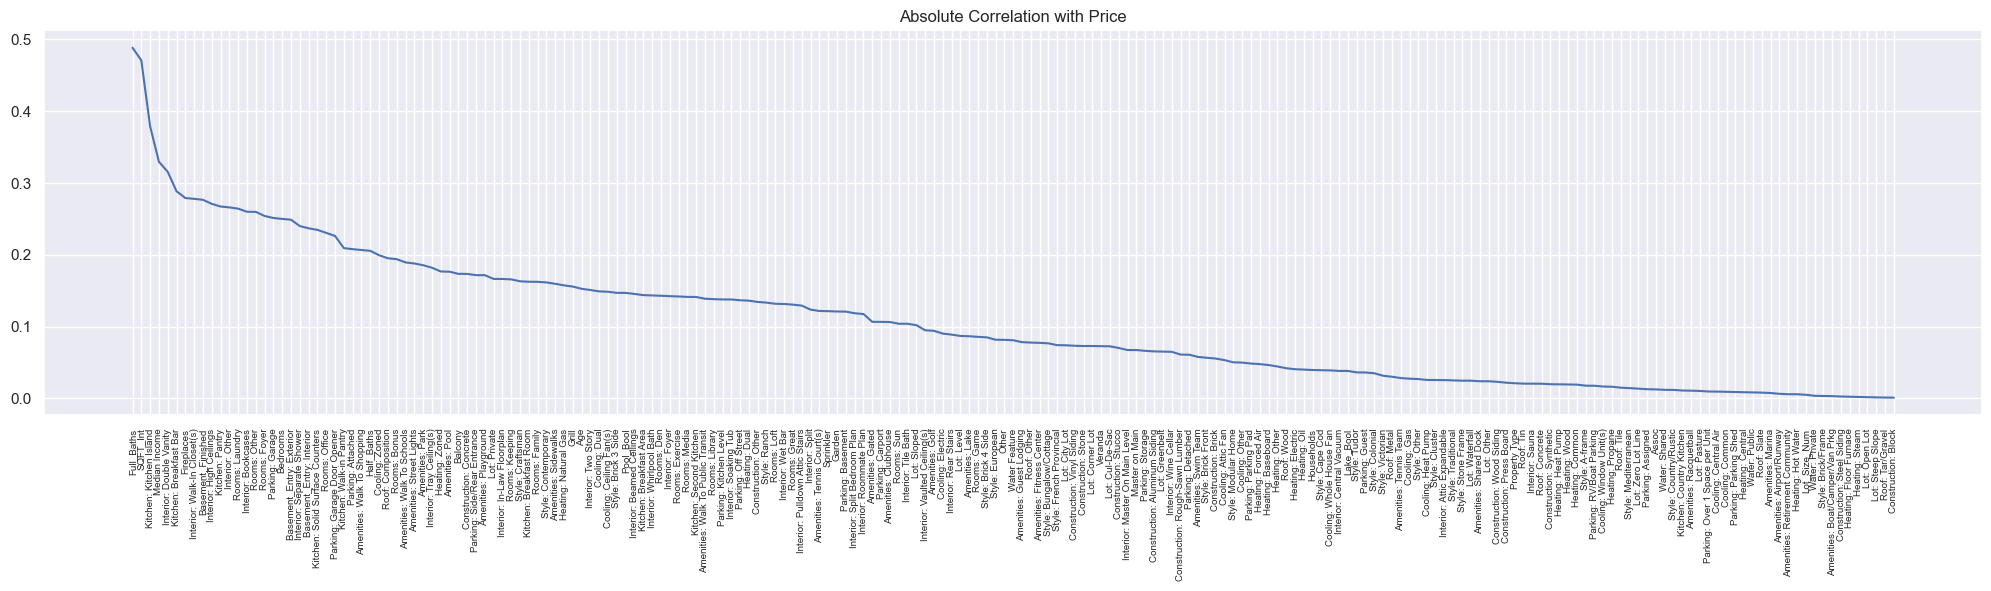

In [197]:
# plot of absolute correlation with price by column
# strongest correlations with square footage, full baths, fireplaces, and wine cellar, but steep dropoff afterwards
price_corr['Abs Price Corr'] = price_corr['Price Corr'].apply(abs)
price_corr.sort_values(by='Abs Price Corr', ascending=False, inplace=True)
top_corr = list(price_corr.index)

fig4 = plt.figure(figsize=(25,5))
plt.plot(price_corr.index, price_corr.loc[:, 'Abs Price Corr'])
plt.xticks(rotation=90, fontsize=7)
plt.title('Absolute Correlation with Price')
plt.savefig('visuals/abs_price_correlation_features.png')

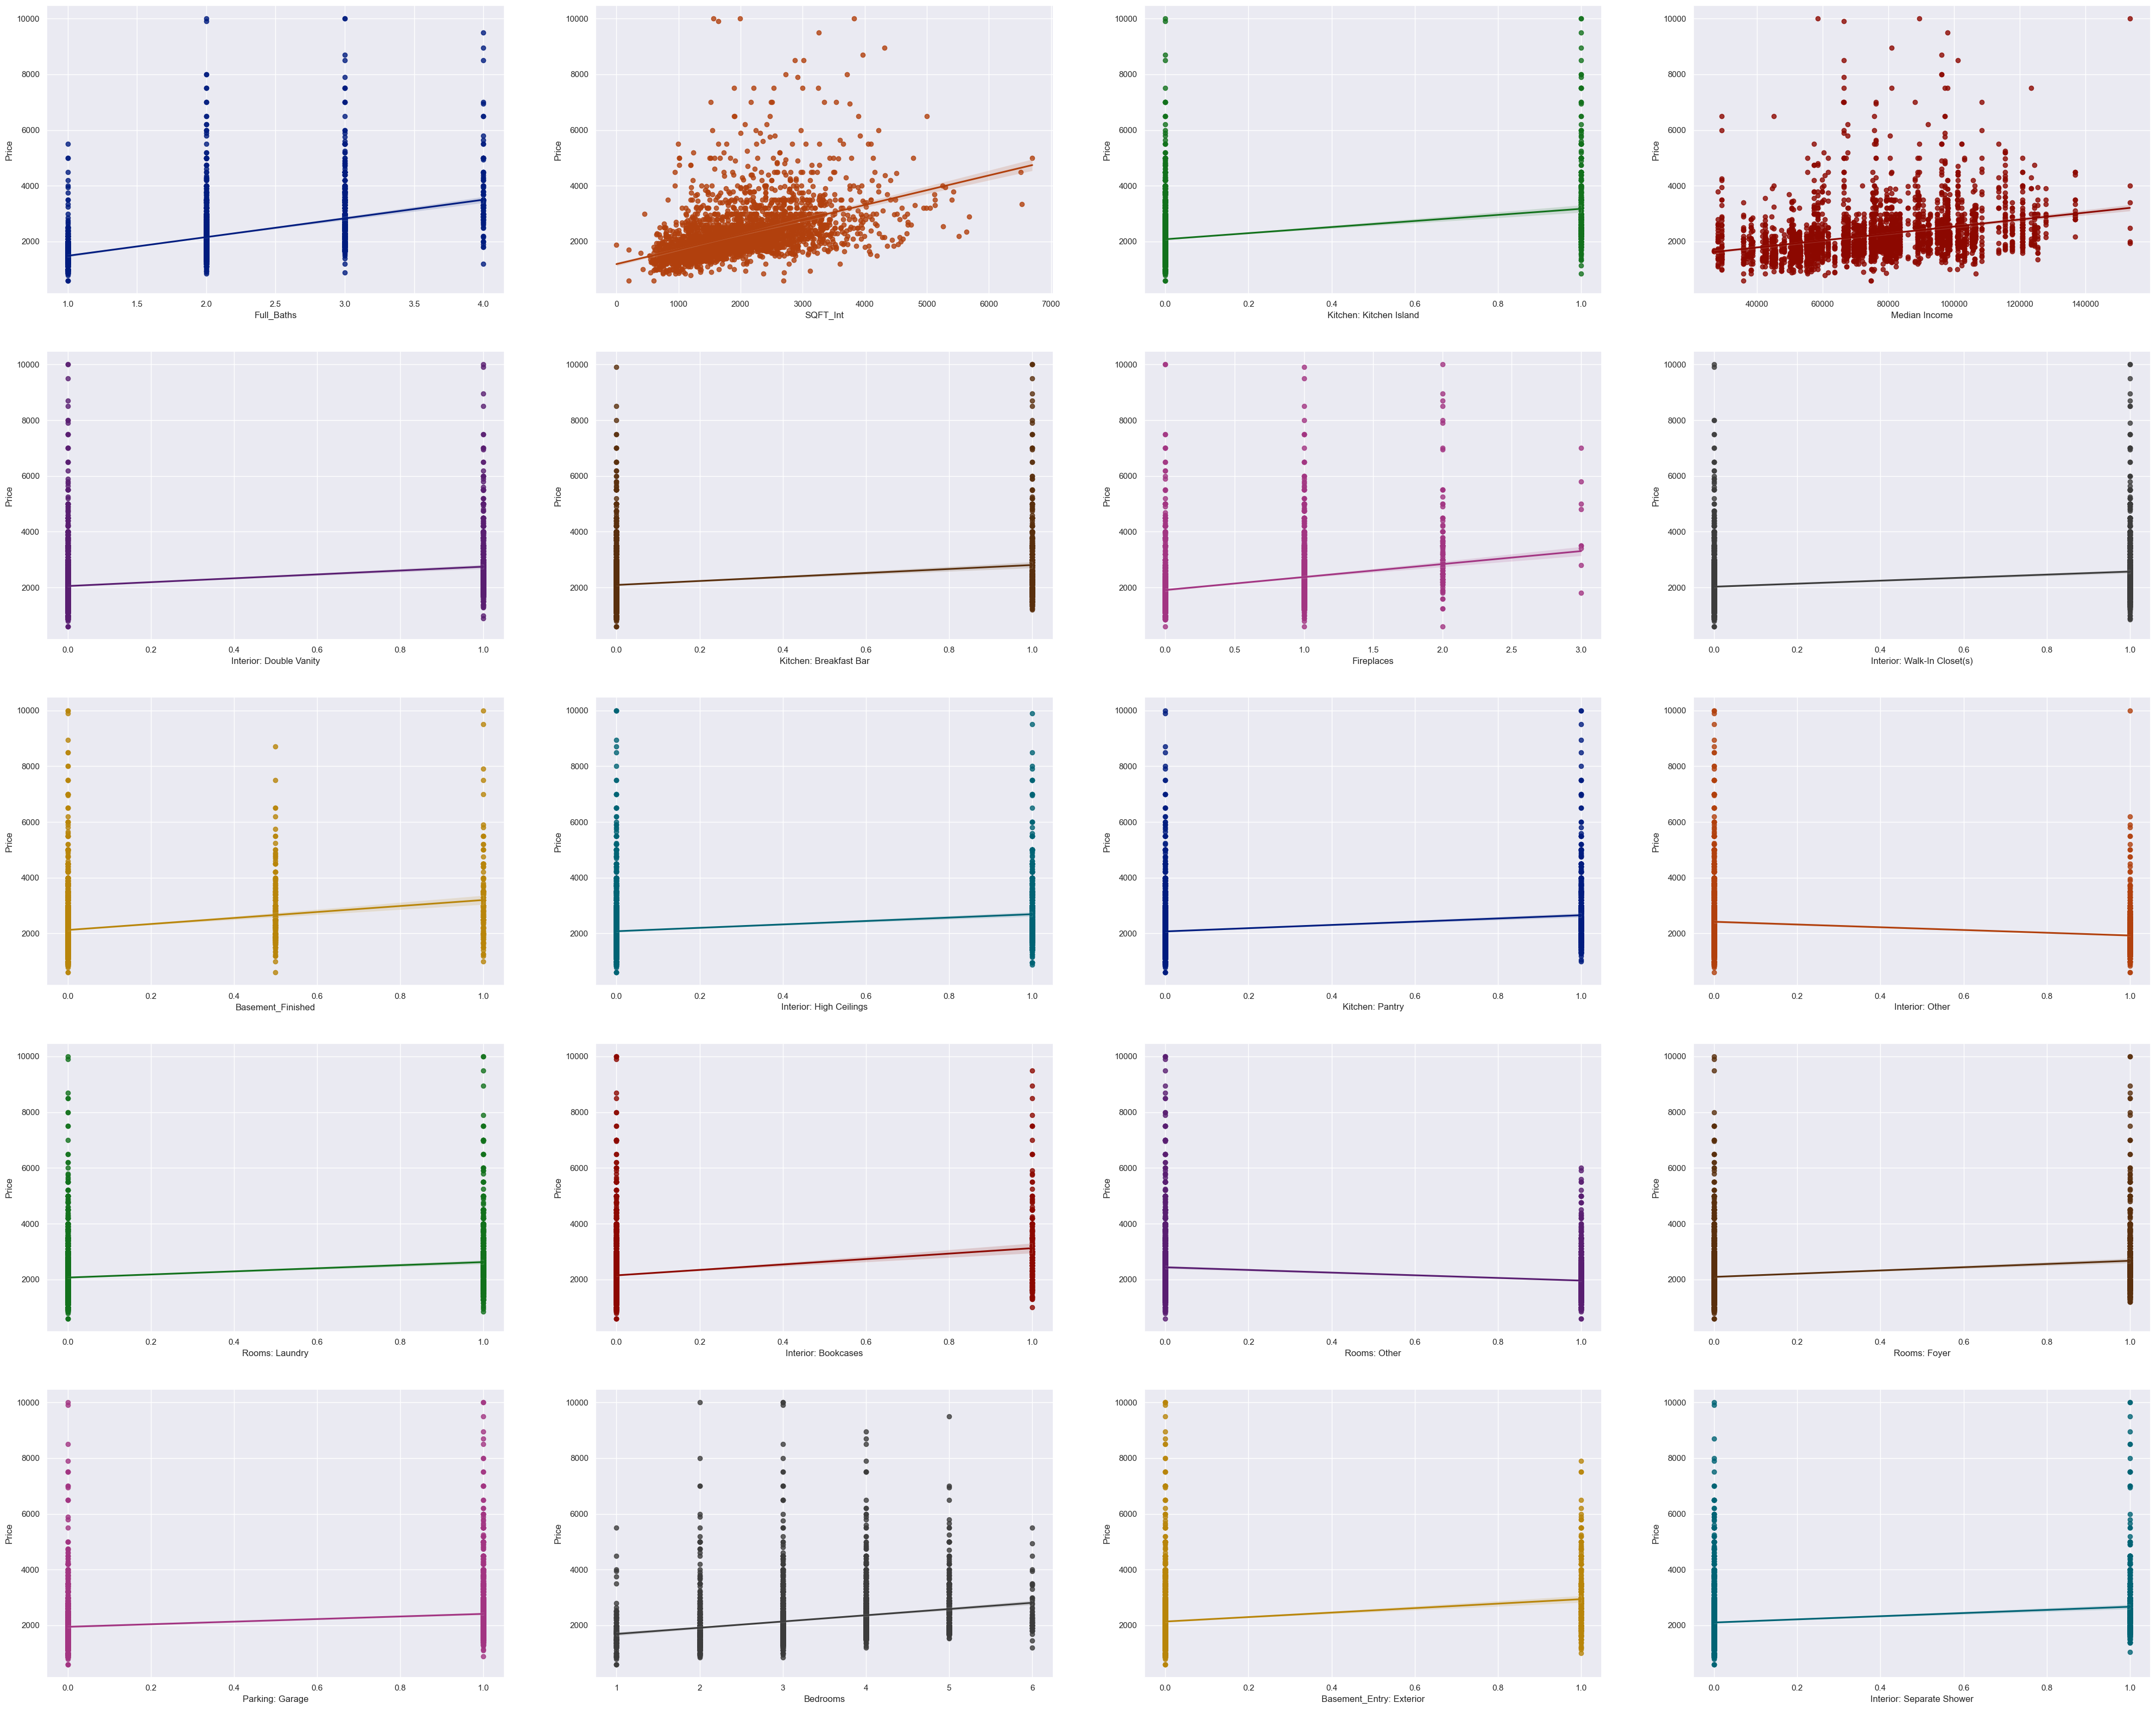

In [198]:
# plots of top 20 correlated columns vs price
# square footage and number of full baths are two best predictors
fig5 = plt.figure(figsize=(50,40))
plt.title('Top 20 Correlated Variables vs. Price')
palette2 = sns.color_palette(palette='dark', n_colors=20)
for i in range(20):
    plt.subplot(5, 4, i+1)
    scatter = sns.regplot(data=fdf, x=fdf[top_corr[i]], y='Price', color=palette2[i])
plt.savefig('visuals/selected_scatter_features.png')

## Standardization

Here we use a standardization technique proposed by Andrew Gelman in [this paper](http://www.stat.columbia.edu/~gelman/research/published/standardizing7.pdf) which divides continuous variables by 2 standard deviations and leaves binary variables unchanged, so that every column has a nearly equivalent scale.

The idea is that, for a binary variable with standard deviation $s$, the difference in its max and min values (0 and 1) represents $1/s$ standard deviations, so we standardize each continuous column such that one unit also represents the same number of standard deviations. 

Average std for binary cols: 0.2094677233989119


<AxesSubplot: ylabel='Frequency'>

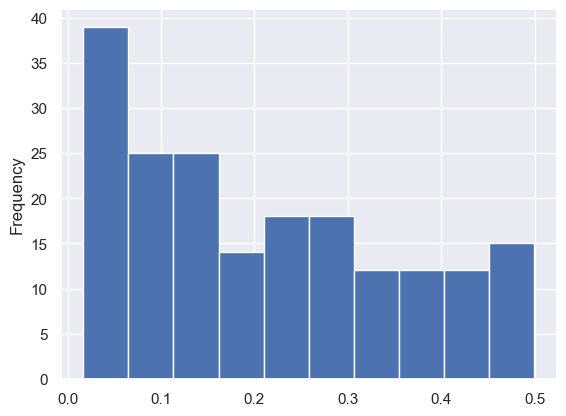

In [199]:
# 2-std technique works best when all binary variables have a standard deviation ~ .5, but can try dividing by more standard deviations

# get all binary categories, view their standard deviations, and compute average
bin_stds = fdf_descr.loc['std', (fdf_descr.loc['max'] == 1) & (fdf.apply(lambda col: len(col.unique())) == 2)]
print(f'Average std for binary cols: {bin_stds.mean()}')
bin_stds.plot.hist()

In [200]:
# normalize all non-categorical columns (and simply mean-center at 0 for categorical columns)
# divide by (1/avg_std ~ 4.7 stds)
fdf = fdf.drop('Price', axis=1).apply(lambda x: (x - np.mean(x)) / (4.7 * np.std(x)) if x.max() != 1 else x - np.mean(x))
fdf['Price'] = ndf['Price']

## Exploratory Factor Analysis

In [201]:
# confirm that data can be factor analyzed
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

# use Bartlett's Test of Sphericity to check if data factorizable
chisq, p = calculate_bartlett_sphericity(fdf.drop('Price', axis=1))

# p-value of null hypothesis that covariance matrix is the identity (which would mean no correlation between columns)
print(f'chisq-value: {chisq}')
print(f'p-value: {p}') # p-value of 0 (<<.05) strongly indicates not identity (significant covariance)


# use Kaiser-Meyer-Olkin (KMO) Test to measure proportion of overall dataset variance that is common variance among the variables (from 0 to 1)
kmo_vars, kmo_model = calculate_kmo(fdf.drop('Price', axis=1))
print(f'kmo-statistic: {kmo_model}') # value of .82 is strong indication that factor analysis can be performed (.6 is minimum acceptable)

chisq-value: 317500.56984397204
p-value: 0.0
kmo-statistic: 0.8149174881428166


In [202]:
# mean variance .065, min variance .00028, max variance .25 (choose factors with greater eigenvalues)
(fdf.drop('Price', axis=1).describe().loc['std', :]**2).describe()

count    201.000000
mean       0.064011
std        0.071083
min        0.000285
25%        0.006804
50%        0.043070
75%        0.096491
max        0.249455
Name: std, dtype: float64

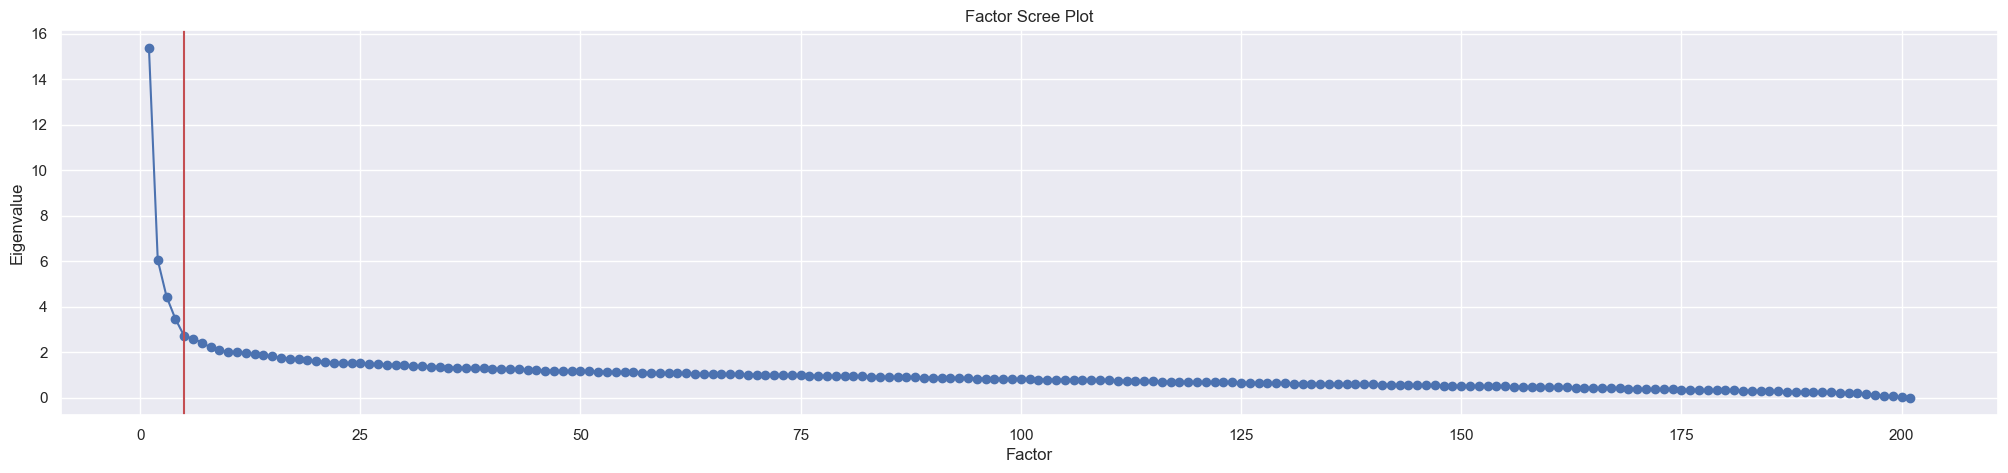

In [203]:
# find and plot all factors and corresponding eigenvalues
from factor_analyzer import FactorAnalyzer

fa = FactorAnalyzer(
    n_factors=1,
    rotation=None,
)

fa.fit(fdf.drop('Price', axis=1))
eigens, _ = fa.get_eigenvalues()

fig6 = plt.figure(figsize=(25,5))
plt.plot(range(1, fdf.drop('Price', axis=1).columns.size+1), eigens, 'bo-') 
plt.axvline(x=5, color='r')
plt.xticks()
plt.title('Factor Scree Plot')
plt.xlabel('Factor')
plt.ylabel('Eigenvalue')
plt.savefig('visuals/factor_scree_plot.png')
plt.show() # from the graph, we see that it is worth looking at the first 4 factors

In [204]:
# create and interpret optimal number of factors
fa = FactorAnalyzer(n_factors=4, rotation='varimax')
fa.fit(fdf.drop('Price', axis=1))


# get loadings (how much each factor explains each variable)
factor_loadings = pd.DataFrame(fa.loadings_, index=fdf.drop('Price', axis=1).columns)

# get factor variances (how much of the total variance each factor explains)
factor_vars = pd.DataFrame(fa.get_factor_variance(), index=['Variance', 'Proportional Var', 'Cumulative Var'])

# get communalities (how much of each variable's variance explained by all the factors)
factor_comms = pd.DataFrame(fa.get_communalities(), index=fdf.drop('Price', axis=1).columns)

print(f'Factor Variances \n {factor_vars}')

Factor Variances 
                           0         1         2         3
Variance          11.800442  5.201380  4.749057  4.713336
Proportional Var   0.058709  0.025878  0.023627  0.023449
Cumulative Var     0.058709  0.084586  0.108213  0.131663


We observe low proportional variances for each factor, but that is to be expected when there are over 200 columns of data in total. The variance accounted for by each of the top factors greatly outperforms the mean and maximum variances of the columns. Some observations:

- Factor 1, interestingly, assigns significant weight to many of the variables which were highly correlated with price (i.e. square footage, full baths, fireplaces, finished basement, office room, bedrooms)
- Factor 2 appears to heavily focus on the different amenities

Overall, it is relatively difficult to tell just by looking at the other factor loadings what each factor represents, so there are likely no easily human-interpretable variables which can help us understand the spread of the dataset.

## Feature Selection

Note that it doesn't make sense to perform principal component analysis for dimensionality reduction, since most of the variables are binary and do not belong on a coordinate plane.

In [205]:
# drop highly correlated columns

# get upper triangle of correlation matrix to avoid duplicates (only removing one column for each correlating pair)
abs_corr = corr.abs()
upper = abs_corr.where(np.triu(np.ones(abs_corr.shape), 1).astype(np.bool8))
to_drop = [col for col in upper.columns if any(upper[col] > .9)] # 3 columns to be dropped

# Master on Main = Interior: Master on Main, Interior: Split Bedroom = Interior: Split, Interior: Two Story = Interior: Foyer
print(f'High Covariance: {to_drop}\n')

# drop columns with low correlation with price
to_drop += [col for col in fdf if upper['Price'][col] < .01]
print(f'Low Price Correlation: {to_drop[3:]}')

# drop columns to create final dataset
data = fdf.drop(to_drop, axis=1)

High Covariance: ['Interior: Master On Main Level', 'Interior: Foyer', 'Interior: Split']

Low Price Correlation: ['Lot_Size_Num', 'Water: Public', 'Water: Private', 'Style: Brick/Frame', 'Heating: Central', 'Heating: Hot Water', 'Heating: Floor Furnace', 'Heating: Steam', 'Cooling: Central Air', 'Cooling: Common', 'Construction: Steel Siding', 'Construction: Block', 'Roof: Tar/Gravel', 'Roof: Slate', 'Parking: Over 1 Space per Unit', 'Parking: Parking Shed', 'Amenities: Airport/Runway', 'Amenities: Marina', 'Amenities: Retirement Community', 'Amenities: Boat/Camper/Van Prkg', 'Lot: Open Lot', 'Lot: Steep Slope']


In [206]:
import pickle

# pickle fdf for use in model training
data.to_pickle('../data/data.pkl')

# pickle imputer for use in prediction script
pickle.dump(imputer, open('imputer.pkl', 'wb'))